In [127]:
import math
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=3)

results_df = []
log_dir = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs/")
for run_dir in os.listdir(log_dir):
    run_path = os.path.join(log_dir, run_dir, "checkpoints/")

    results = glob.glob(run_path+"*.pickle")
    for result in results:
        df = pd.read_pickle(result)
        df = pd.DataFrame.from_records(df)
        df["dir_name"] = run_dir
        df["epoch"] = int(result.split("epoch=")[1].split("-")[0])
        results_df.append(df)


results_df = pd.concat(results_df, ignore_index=True)

# Remove superfluous NaN cells
def compress(values):
    for val in values:
        if val is not None and not np.isnan(val):
            return val

results_df = results_df.groupby(["dir_name", "epoch"]).aggregate(compress)
results_df.reset_index(inplace=True)
results_df

,dir_name,epoch,message_lengths/dataloader_idx_0,receiver_message_lengths/dataloader_idx_0,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,policy_loss/dataloader_idx_0,policy_length_loss/dataloader_idx_0,val_acc,val_acc_no_noise,...,receiver_loss/dataloader_idx_1,entropy_loss/dataloader_idx_1,policy_loss/dataloader_idx_1,policy_length_loss/dataloader_idx_1,message_lengths/dataloader_idx_2,receiver_message_lengths/dataloader_idx_2,receiver_loss/dataloader_idx_2,entropy_loss/dataloader_idx_2,policy_loss/dataloader_idx_2,policy_length_loss/dataloader_idx_2
0,version_1058286,2599,4.0,NaN,0.014002,0.215065,-0.089586,0.0,1.000000,1.000000,...,0.085979,0.222591,-0.472564,0.0,3.990339,NaN,0.002310,0.223594,-0.013691,0.0
1,version_1058287,3199,4.0,NaN,0.055967,0.208567,-0.278934,0.0,0.869565,1.000000,...,0.041783,0.212006,-0.248042,0.0,4.000000,NaN,0.001240,0.207243,-0.007485,0.0
2,version_1058288,3999,4.0,NaN,0.309793,0.233748,-2.159579,0.0,0.652174,0.652174,...,0.541377,0.231743,-3.194933,0.0,4.000000,NaN,0.001451,0.219853,-0.009459,0.0
3,version_1058289,3199,4.0,1.934783,0.050755,0.300532,-0.290637,0.0,0.956522,1.000000,...,0.126235,0.295199,-0.570124,0.0,3.975845,1.816425,0.001289,0.296562,-0.006829,0.0
4,version_1058290,2599,4.0,NaN,0.008154,0.243056,-0.056412,0.0,1.000000,1.000000,...,0.039491,0.247275,-0.299365,0.0,4.000000,NaN,0.001511,0.240063,-0.010613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,version_1058453,2699,9.0,4.043478,0.053156,2.354027,-1.525456,0.0,0.956522,1.000000,...,0.125125,2.349162,-3.696918,0.0,8.985507,4.169082,0.010162,2.366326,-0.305715,0.0
169,version_1058454,2899,9.0,NaN,0.046711,1.945573,-1.360741,0.0,1.000000,1.000000,...,0.084658,1.948184,-2.449987,0.0,9.000000,NaN,0.007079,1.957281,-0.206715,0.0
170,version_1058456,4799,9.0,NaN,0.043409,1.922994,-1.239433,0.0,0.956522,1.000000,...,0.074443,1.948452,-2.120115,0.0,9.000000,NaN,0.005493,1.944384,-0.157208,0.0
171,version_1058457,3699,9.0,3.673913,0.076860,2.394127,-2.160541,0.0,0.869565,0.956522,...,0.063570,2.346415,-1.789730,0.0,9.000000,4.173913,0.007131,2.381296,-0.207547,0.0


In [ ]:
from tbparse import SummaryReader

# TODO do manual faster loading without tbparse!
reader = SummaryReader(log_dir, extra_columns={'dir_name'}, pivot=True, event_types={"hparams"})

hp = reader.hparams
hp_original = hp.copy()

In [128]:
def fix_duplicate_value(val, allow_offset=None):
    if isinstance(val, list):
        for el in val:
            if allow_offset is None:
                assert (el == val[0]) or (el == "None") or (val[0] == "None")
            else:
                assert (np.abs(el - val[0]) < allow_offset) or (el == "None") or (val[0] == "None")
        return val[0]
    else:
        return val

hp = hp.applymap(fix_duplicate_value)

In [135]:
REFERENCE_METRIC = "val_acc"

indices_best_steps = results_df.groupby("dir_name")[REFERENCE_METRIC].idxmax()

df = results_df.loc[list(indices_best_steps)].copy()
df

,dir_name,epoch,message_lengths/dataloader_idx_0,receiver_message_lengths/dataloader_idx_0,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,policy_loss/dataloader_idx_0,policy_length_loss/dataloader_idx_0,val_acc,val_acc_no_noise,...,receiver_loss/dataloader_idx_1,entropy_loss/dataloader_idx_1,policy_loss/dataloader_idx_1,policy_length_loss/dataloader_idx_1,message_lengths/dataloader_idx_2,receiver_message_lengths/dataloader_idx_2,receiver_loss/dataloader_idx_2,entropy_loss/dataloader_idx_2,policy_loss/dataloader_idx_2,policy_length_loss/dataloader_idx_2
0,version_1058286,2599,4.0,NaN,0.014002,0.215065,-0.089586,0.0,1.000000,1.000000,...,0.085979,0.222591,-0.472564,0.0,3.990339,NaN,0.002310,0.223594,-0.013691,0.0
1,version_1058287,3199,4.0,NaN,0.055967,0.208567,-0.278934,0.0,0.869565,1.000000,...,0.041783,0.212006,-0.248042,0.0,4.000000,NaN,0.001240,0.207243,-0.007485,0.0
2,version_1058288,3999,4.0,NaN,0.309793,0.233748,-2.159579,0.0,0.652174,0.652174,...,0.541377,0.231743,-3.194933,0.0,4.000000,NaN,0.001451,0.219853,-0.009459,0.0
3,version_1058289,3199,4.0,1.934783,0.050755,0.300532,-0.290637,0.0,0.956522,1.000000,...,0.126235,0.295199,-0.570124,0.0,3.975845,1.816425,0.001289,0.296562,-0.006829,0.0
4,version_1058290,2599,4.0,NaN,0.008154,0.243056,-0.056412,0.0,1.000000,1.000000,...,0.039491,0.247275,-0.299365,0.0,4.000000,NaN,0.001511,0.240063,-0.010613,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,version_1058452,2199,9.0,NaN,0.072157,1.935203,-1.939643,0.0,0.913043,1.000000,...,0.111863,1.946255,-3.093214,0.0,8.995169,NaN,0.030891,1.949524,-0.835683,0.0
168,version_1058453,2699,9.0,4.043478,0.053156,2.354027,-1.525456,0.0,0.956522,1.000000,...,0.125125,2.349162,-3.696918,0.0,8.985507,4.169082,0.010162,2.366326,-0.305715,0.0
169,version_1058454,2899,9.0,NaN,0.046711,1.945573,-1.360741,0.0,1.000000,1.000000,...,0.084658,1.948184,-2.449987,0.0,9.000000,NaN,0.007079,1.957281,-0.206715,0.0
170,version_1058456,4799,9.0,NaN,0.043409,1.922994,-1.239433,0.0,0.956522,1.000000,...,0.074443,1.948452,-2.120115,0.0,9.000000,NaN,0.005493,1.944384,-0.157208,0.0


In [136]:
df.set_index("dir_name", inplace=True, drop=False)
if not hp.index.name == "dir_name":
    hp.set_index("dir_name", inplace=True, verify_integrity=True)
df = df.join(hp, how="left")

In [137]:
MAX_N_RUNS = 10
df.dropna(subset=["num_attributes", "num_values"], inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        # length_cost_values = df["length_cost"].unique()
        length_cost_values = [0, 0.001]
        for length_cost in length_cost_values:

            max_len_values = df.max_len.unique()
            for max_len in max_len_values:

                noise_values = df.noise.unique()
                for noise in noise_values:
                    for feedback in (0, 1):
                        for self_repair in (0, 1):

                            df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.feedback == feedback) & (df.num_agents == num_agents) & (df.noise == noise) & (df.self_repair == self_repair) & (df.max_len == max_len)]

                            if len(df_config) == 0:
                                continue

                            print(f"\t\t\tLength cost: {length_cost}\t Noise: {noise}\tmax_len: {max_len}", end="")

                            if feedback:
                                print("\tFeedback", end="")
                            elif self_repair:
                                print("\tSelf repair", end="")
                            else:
                                print("\tBaseline", end="")

                            print(f"\tFound {len(df_config)} runs") #: {df_config}

                            avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({REFERENCE_METRIC: "mean"})
                            # Take the highest entropy coeff in case of tie
                            best_entropy_coeff = avg_val_accs[avg_val_accs[REFERENCE_METRIC] == avg_val_accs.max()[0]].index[-1]

                            df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]
                            print(f"\t\t\t\t\t\tbest entropy coeff: {best_entropy_coeff}; num runs: {len(df_best_entropy)}", end="")
                            print(f"\tother: {avg_val_accs.to_dict()})", )

                            if len(df_best_entropy) > MAX_N_RUNS:
                                df_best_entropy = df_best_entropy.tail(10)
                            runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)





Num agents: 1.0

		Attr: 4 Values: 4
			Length cost: 0	 Noise: 0.0	max_len: 5.0	Baseline	Found 15 runs
						best entropy coeff: 0.3; num runs: 5	other: {'val_acc': {0.1: 0.895652174949646, 0.3: 0.913043475151062, 0.5: 0.826086962223053}})
			Length cost: 0	 Noise: 0.1	max_len: 5.0	Baseline	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.860869562625885, 0.3: 0.808695650100708, 0.5: 0.852173924446106}})
			Length cost: 0	 Noise: 0.1	max_len: 5.0	Self repair	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.808695650100708, 0.3: 0.747826075553894, 0.5: 0.7826086997985839}})
			Length cost: 0	 Noise: 0.1	max_len: 5.0	Feedback	Found 15 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.834782600402832, 0.3: 0.704347825050354, 0.5: 0.6695652067661285}})
			Length cost: 0	 Noise: 0.0	max_len: 10.0	Baseline	Found 13 runs
						best entropy coeff: 0.3; num runs: 4	other: {'val_acc': {0.1: 1.0, 0.3: 

In [138]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

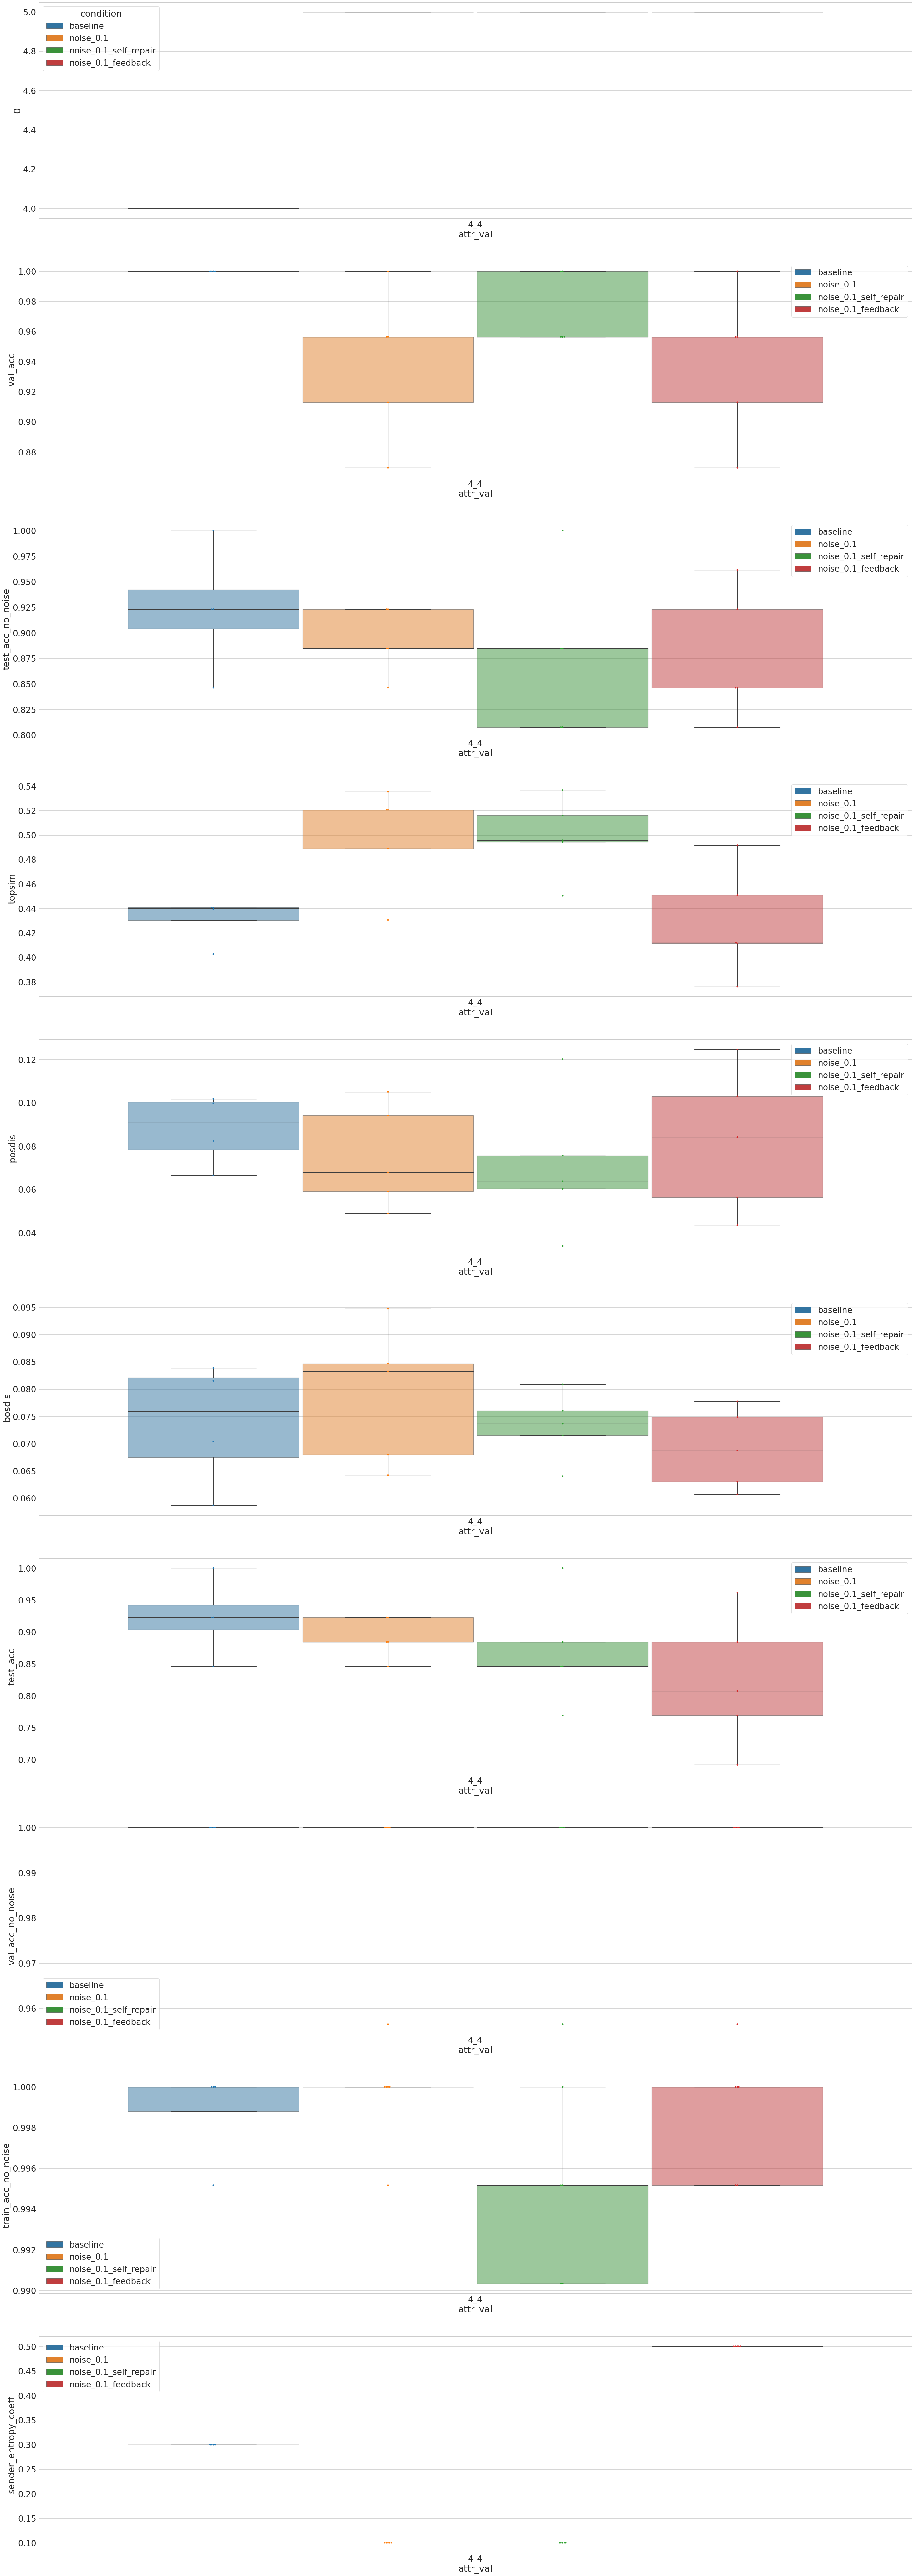

In [139]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["self_repair"].map(lambda x: "_self_repair" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: num_agents setting
NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

# ATTR_VAL = "4_5"
# target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_self_repair", "noise_0.1_feedback"]

# order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]
order = ["4_4"]


target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(10, 1, figsize=(50, 150))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc", "test_acc_no_noise", "topsim", "posdis", "bosdis", "test_acc", "val_acc_no_noise", "train_acc_no_noise", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)

In [ ]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["self_repair"].map(lambda x: "_binary" if x else "") #+ data["num_agents"].map(lambda x: "_2_agents" if x else "")

# Exclude bad noise setting
target_data = data[~(data.noise == 0.3)]

# TODO: open CR setting
# target_data = target_data[target_data.self_repair == 0]

# TODO: num_agents setting
NUM_AGENTS = 2
target_data = target_data[target_data.num_agents == NUM_AGENTS]


ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_length_cost_0.001", "noise_0.1_length_cost_0.001_feedback"]
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]#, , "noise_0.1_length_cost_0.001_feedback","noise_0.1_length_cost_0.001_feedback"]#, "noise_0.1_length_cost_0.01_feedback"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback", "noise_0.1_feedback_binary"]

order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(8, 1, figsize=(50, 100))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc", "test_acc_no_noise", "test_acc", "topsim", "posdis", "bosdis", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)